In [1]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import math

import sys
# from meep.materials import SiN

In [2]:
# 물질 설정 및 Refractive Index 설정
mp.verbosity(0)
um_scale = 2

Air = mp.Medium(index=1.0)
SiN = mp.Medium(epsilon=4)
SiO2 = mp.Medium(epsilon=2.1)
SiPD = mp.Medium(epsilon=5)

In [3]:
resolution = 25 # 해상도
design_region_width = 2 # 디자인 영역 x
design_region_width_y = 2 # 디자인 영역 y
design_region_height = 4 # 디자인 영역 높이 z
pml_size = 1.0 # PML 영역 크기

In [4]:
structure_weight = np.loadtxt('lastdesign.txt')

In [5]:
# 시뮬레이션 공간 설정
Sx = design_region_width
Sy = design_region_width_y
Sz = 2 * pml_size + design_region_height + 2
cell_size = mp.Vector3(Sx, Sy, Sz)

In [6]:
# 파장, 주파수 설정
wavelengths = np.array([0.43*um_scale, 0.45*um_scale, 0.47*um_scale, 0.53*um_scale, 0.55*um_scale, 0.57*um_scale, 0.62*um_scale, 0.65*um_scale, 0.68*um_scale])
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

In [7]:
minimum_length = 0.05  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

In [8]:
pml_layers = [mp.PML(thickness = pml_size, direction = mp.Z)]

In [9]:
width = 0.1
fcen_red0 = frequencies[6]
fwidth_red0 = width * fcen_red0
fcen_red1 = frequencies[7]
fwidth_red1 = width * fcen_red1
fcen_red2 = frequencies[8]
fwidth_red2 = width * fcen_red2

fcen_green0 = frequencies[3]
fwidth_green0 = width * fcen_green0
fcen_green1 = frequencies[4]
fwidth_green1 = width * fcen_green1
fcen_green2 = frequencies[5]
fwidth_green2 = width * fcen_green2

fcen_blue0 = frequencies[0]
fwidth_blue0 = width * fcen_blue0
fcen_blue1 = frequencies[1]
fwidth_blue1 = width * fcen_blue1
fcen_blue2 = frequencies[2]
fwidth_blue2 = width * fcen_blue2

In [10]:
source_center = [0, 0, Sz / 2 - pml_size - 0.5] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)

src_0 = mp.GaussianSource(frequency=fcen_red2, fwidth=fwidth_red2, is_integrated=True)
src_1 = mp.GaussianSource(frequency=fcen_red1, fwidth=fwidth_red1, is_integrated=True)
src_2 = mp.GaussianSource(frequency=fcen_red0, fwidth=fwidth_red0, is_integrated=True)
src_3 = mp.GaussianSource(frequency=fcen_green2, fwidth=fwidth_green2, is_integrated=True)
src_4 = mp.GaussianSource(frequency=fcen_green1, fwidth=fwidth_green1, is_integrated=True)
src_5 = mp.GaussianSource(frequency=fcen_green0, fwidth=fwidth_green0, is_integrated=True)
src_6 = mp.GaussianSource(frequency=fcen_blue2, fwidth=fwidth_blue2, is_integrated=True)
src_7 = mp.GaussianSource(frequency=fcen_blue1, fwidth=fwidth_blue1, is_integrated=True)
src_8 = mp.GaussianSource(frequency=fcen_blue0, fwidth=fwidth_blue0, is_integrated=True)

source = [mp.Source(src_0, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_1, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_2, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_3, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_4, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_5, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_6, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_7, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_8, component=mp.Ey, size=source_size, center=source_center)]


In [11]:
Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_width_y)) + 1
Nz = int(round(design_region_resolution * design_region_height)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), SiO2, SiN, grid_type="U_MEAN")



In [12]:
design_variables.update_weights(structure_weight)

In [13]:
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, 0),
        size=mp.Vector3(design_region_width, design_region_width_y, design_region_height),
    ),
)


In [14]:
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(0, 0, -3), size=mp.Vector3(Sx, Sy, 2), material=SiPD
    ),
]

In [15]:
sim = mp.Simulation(
    cell_size=cell_size, 
    # boundary_layers=pml_layers,
    geometry=geometry,
    # sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-Sx/4, Sy/4, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-Sx/4, -Sy/4, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(Sx/4, -Sy/4, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(Sx/4, Sy/4, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함
FourierFields_0 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_1 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_2 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_3 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_4 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_5 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_6 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_7 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_8 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_9 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
FourierFields_10 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
FourierFields_11 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
ob_list = [FourierFields_0, FourierFields_1, FourierFields_2,FourierFields_3, FourierFields_4, FourierFields_5 ,FourierFields_6, FourierFields_7, FourierFields_8,FourierFields_9, FourierFields_10, FourierFields_11]


# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 Ez 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
def J_0(fields_0, fields_1, fields_2,fields_3, fields_4, fields_5,fields_6, fields_7, fields_8,fields_9, fields_10, fields_11):
    return npa.mean(npa.abs(fields_0[6,:]) ** 2) + npa.mean(npa.abs(fields_1[7,:]) ** 2) + npa.mean(npa.abs(fields_2[8,:]) ** 2) + npa.mean(npa.abs(fields_3[3,:]) ** 2) + npa.mean(npa.abs(fields_4[4,:]) ** 2) + npa.mean(npa.abs(fields_5[5,:]) ** 2) + npa.mean(npa.abs(fields_6[0,:]) ** 2) + npa.mean(npa.abs(fields_7[1,:]) ** 2) + npa.mean(npa.abs(fields_8[2,:]) ** 2) + npa.mean(npa.abs(fields_9[3,:]) ** 2) + npa.mean(npa.abs(fields_10[4,:]) ** 2) + npa.mean(npa.abs(fields_11[5,:]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_0],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-5
)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


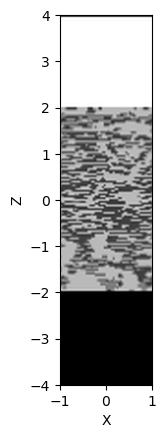

In [16]:
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))
plt.savefig("Lastdesignxz.png")

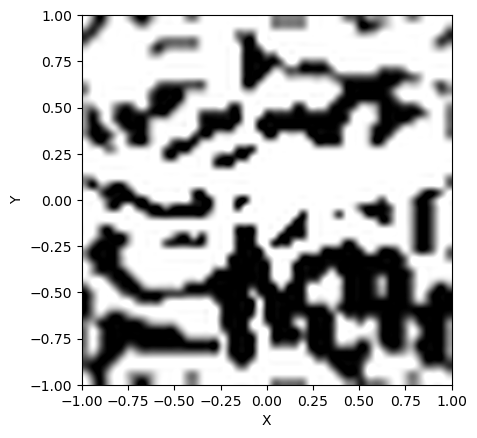

In [17]:
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, np.inf, 0), center = (0,0,2)))
plt.savefig("Lastdesignxy.png")

In [18]:
rot_angle = np.radians(6)

In [19]:
k_point = mp.Vector3(z = -1).rotate(mp.Vector3(y=1), rot_angle) # fsrc*n 의 크기를 갖는 vector를 +z축에서 rot_angle 만큼 기울게만든 것                                                                    

In [20]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = k_point,
)
src = mp.GaussianSource(frequency=frequencies[0], fwidth=fwidth_blue0, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total0 = opt.sim.add_dft_fields([mp.Ey], frequencies[0], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

plt.title('wavelength = '+str(wavelengths[0]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux0 = np.abs(opt.sim.get_dft_array(tran_total0, mp.Ey, 0))**2
total_flux0 = (total_flux0 / total_flux0.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux0.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Blues")
#plt.fill([40, 40, 80, 80], [80, 40, 40, 80], color='lightblue', alpha=0.5)
#plt.fill([40, 40, 80, 80], [40, 0, 0, 40], color='lightgreen', alpha=0.5)
#plt.fill([0, 0, 40, 40], [40, 0, 0, 40], color='lightcoral', alpha=0.5)
#plt.fill([0, 0, 40, 40], [80, 40, 40, 80], color='lightgreen', alpha=0.5)
plt.colorbar()
plt.savefig("Intensityplotf0" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [21]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)
src = mp.GaussianSource(frequency=frequencies[1], fwidth=fwidth_blue1, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total1 = opt.sim.add_dft_fields([mp.Ey], frequencies[1], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

plt.title('wavelength = '+str(wavelengths[1]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux1 = np.abs(opt.sim.get_dft_array(tran_total1, mp.Ey, 0))**2
total_flux1 = (total_flux1 / total_flux1.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux1.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Blues")
#plt.fill([40, 40, 80, 80], [80, 40, 40, 80], color='lightblue', alpha=0.5)
#plt.fill([40, 40, 80, 80], [40, 0, 0, 40], color='lightgreen', alpha=0.5)
#plt.fill([0, 0, 40, 40], [40, 0, 0, 40], color='lightcoral', alpha=0.5)
#plt.fill([0, 0, 40, 40], [80, 40, 40, 80], color='lightgreen', alpha=0.5)
plt.colorbar()
plt.savefig("Intensityplotf1" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [22]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)
src = mp.GaussianSource(frequency=frequencies[2], fwidth=fwidth_blue2, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total2 = opt.sim.add_dft_fields([mp.Ey], frequencies[2], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

plt.title('wavelength = '+str(wavelengths[2]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux2 = np.abs(opt.sim.get_dft_array(tran_total2, mp.Ey, 0))**2
total_flux2 = (total_flux2 / total_flux2.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux2.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Blues")
#plt.fill([40, 40, 80, 80], [80, 40, 40, 80], color='lightblue', alpha=0.5)
#plt.fill([40, 40, 80, 80], [40, 0, 0, 40], color='lightgreen', alpha=0.5)
#plt.fill([0, 0, 40, 40], [40, 0, 0, 40], color='lightcoral', alpha=0.5)
#plt.fill([0, 0, 40, 40], [80, 40, 40, 80], color='lightgreen', alpha=0.5)
plt.colorbar()
plt.savefig("Intensityplotf2" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [23]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)
src = mp.GaussianSource(frequency=frequencies[3], fwidth=fwidth_green0, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total3 = opt.sim.add_dft_fields([mp.Ey], frequencies[3], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

plt.title('wavelength = '+str(wavelengths[3]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux3 = np.abs(opt.sim.get_dft_array(tran_total3, mp.Ey, 0))**2
total_flux3 = (total_flux3 / total_flux3.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux3.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Greens")
plt.colorbar()
plt.savefig("Intensityplotf3" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [24]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)
src = mp.GaussianSource(frequency=frequencies[4], fwidth=fwidth_green1, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total4 = opt.sim.add_dft_fields([mp.Ey], frequencies[4], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

plt.title('wavelength = '+str(wavelengths[4]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux4 = np.abs(opt.sim.get_dft_array(tran_total4, mp.Ey, 0))**2
total_flux4 = (total_flux4 / total_flux4.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux4.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Greens")
plt.colorbar()
plt.savefig("Intensityplotf4" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [25]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)
src = mp.GaussianSource(frequency=frequencies[5], fwidth=fwidth_green2, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total5 = opt.sim.add_dft_fields([mp.Ey], frequencies[5], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

plt.title('wavelength = '+str(wavelengths[5]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux5 = np.abs(opt.sim.get_dft_array(tran_total5, mp.Ey, 0))**2
total_flux5 = (total_flux5 / total_flux5.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux5.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Greens")
plt.colorbar()
plt.savefig("Intensityplotf5" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [26]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)


src = mp.GaussianSource(frequency=frequencies[6], fwidth=fwidth_red0, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total6 = opt.sim.add_dft_fields([mp.Ey], frequencies[6], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)


plt.title('wavelength = '+str(wavelengths[6]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux6 = np.abs(opt.sim.get_dft_array(tran_total6, mp.Ey, 0))**2
total_flux6 = (total_flux6 / total_flux6.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux6.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Reds")
plt.colorbar()
plt.savefig("Intensityplotf6" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [27]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)


src = mp.GaussianSource(frequency=frequencies[7], fwidth=fwidth_red1, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total7 = opt.sim.add_dft_fields([mp.Ey], frequencies[7], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)


plt.title('wavelength = '+str(wavelengths[7]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux7 = np.abs(opt.sim.get_dft_array(tran_total7, mp.Ey, 0))**2
total_flux7 = (total_flux7 / total_flux7.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux7.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Reds")
plt.colorbar()
plt.savefig("Intensityplotf7" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [28]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)


src = mp.GaussianSource(frequency=frequencies[8], fwidth=fwidth_red2, is_integrated=True)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)

plt.figure()

tran_total8 = opt.sim.add_dft_fields([mp.Ey], frequencies[8], 0 , 1, center = (0,0,-2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)


plt.title('wavelength = '+str(wavelengths[8]/um_scale))
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))
total_flux8 = np.abs(opt.sim.get_dft_array(tran_total8, mp.Ey, 0))**2
total_flux8 = (total_flux8 / total_flux8.max(axis=0).max(axis=0))
plt.imshow(npa.rot90(total_flux8.reshape(Sx* resolution+1, Sy* resolution+1 + 1)),cmap="Reds")
plt.colorbar()
plt.savefig("Intensityplotf8" + str(rot_angle) + ".png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [29]:
opt.sim.reset_meep()
#simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), material=Air
    )
]

In [30]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)
fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [31]:
#reflection moniter 설정

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, Sz/2 - pml_size - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0)
) 
refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

#transmission moiniter 설정

tran_t = mp.FluxRegion(
    center=mp.Vector3(0, 0, -2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0)
)
tran_total = opt.sim.add_flux(fcen, df, nfreq, tran_t)


#pt는 transmitted flux region과 동일

pt = mp.Vector3(0, 0, -2 - 0.5/resolution)


#source가 끝난 후에 50 동안 계속 실행하며 component는 Ey, pt 설계의 끝에서 |Ey|^2의 값이 최대 값으로부터 1/1000 만큼 감쇠할때까지
#추가적인 50 단위의 시간 실행 -> Fourier-transform 수렴예상

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-9))

#데이터 저장

straight_refl_data = opt.sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)

In [32]:
opt.sim.reset_meep()

#simulation 2 : geometry가 있는 구조

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    # extra_materials=[SiN],
    k_point = k_point,
)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.EigenModeSource(
    src=src,
    center=source_center,
    size=source_size,
    direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
    eig_kpoint=k_point,
    eig_band=1,
    eig_parity=mp.ODD_Y,
    eig_match_freq=True,
),
 ]
opt.sim.change_sources(source)
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure

In [33]:
# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, -2 - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0)
)
tran = opt.sim.add_flux(fcen, df, nfreq, tran_fr)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.

opt.sim.load_minus_flux_data(refl, straight_refl_data)

#각각 픽셀의 flux 구하기

tran_r = mp.FluxRegion(
    center=mp.Vector3(-Sx/4, Sy/4, -2 - 0.5/resolution), size=mp.Vector3(Sx/2, Sy/2, 0)
)
tran_g = mp.FluxRegion(
    center=mp.Vector3(-Sx/4, -Sy/4, -2 - 0.5/resolution), size=mp.Vector3(Sx/2, Sy/2, 0)
)
tran_b = mp.FluxRegion(
    center=mp.Vector3(Sx/4, -Sy/4, -2 - 0.5/resolution), size=mp.Vector3(Sx/2, Sy/2, 0)
)
tran_g0 = mp.FluxRegion(
    center=mp.Vector3(Sx/4, Sy/4, -2 - 0.5/resolution), size=mp.Vector3(Sx/2, Sy/2, 0)
)

tran_red = opt.sim.add_flux(fcen, df, nfreq, tran_r)
tran_green = opt.sim.add_flux(fcen, df, nfreq, tran_g)
tran_blue = opt.sim.add_flux(fcen, df, nfreq, tran_b)
tran_green0 = opt.sim.add_flux(fcen, df, nfreq, tran_g0)

In [34]:
pt = mp.Vector3(0, 0, -2 - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-9))

#데이터 저장

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

red_flux = mp.get_fluxes(tran_red)
green_flux = mp.get_fluxes(tran_green)
blue_flux = mp.get_fluxes(tran_blue)
green_flux0 = mp.get_fluxes(tran_green0)

In [35]:
wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / total_flux[i])
    Tg = np.append(Tg, green_flux[i] / total_flux[i])
    Tb = np.append(Tb, blue_flux[i] / total_flux[i])
    Tg0 = np.append(Tg0, green_flux0[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig("Transmission" + str(rot_angle) + ".png")
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [36]:
Rs = []
Ts = []
for i in range(nfreq):
    Rs = np.append(Rs, -bend_refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig("Transmission2" + str(rot_angle) + ".png")
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [37]:
wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / bend_tran_flux[i])
    Tg = np.append(Tg, green_flux[i] / bend_tran_flux[i])
    Tb = np.append(Tb, blue_flux[i] / bend_tran_flux[i])
    Tg0 = np.append(Tg0, green_flux0[i] / bend_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg+Tg0, "g", label="Greenpixel")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    #plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Optical Efficiency")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="right")
    #plt.show()
    plt.savefig("Transmission3" + str(rot_angle) + ".png")
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [38]:
print(max(Tr))
print(max(Tb))
print(max(Tg+Tg0))
print(max(Tg0))

0.5269053671071472
0.739932910023539
0.7616858970302447
0.34246123553994795


In [39]:
print(max((Tr-(Tg+Tg0))[0:100]))
print(max((Tb-(Tg+Tg0))[200:300]))
print(max(((Tg+Tg0)-Tr)[100:200]))

0.12727673146967045
0.5238464662081147
0.6155117148045351


In [40]:
print(np.mean((Tr)[100:300]))

0.14878745524193776


In [41]:
print(np.mean((Tb)[0:200]))

0.18940953453516737


In [42]:
print(np.mean((Tg)[0:100]+(Tg)[200:300])/2)

0.2551442748798781


In [43]:
print(np.mean((Tg0)[0:100]+(Tg0)[200:300])/2)

0.18750370380133352


In [44]:
print(np.mean((Tr)[0:100]))
print(np.mean((Tr)[100:200]))
print(np.mean((Tr)[200:300]))

0.34419978009991253
0.1850253156798035
0.11254959480407202


In [45]:
print(np.mean((Tb)[0:100]))
print(np.mean((Tb)[100:200]))
print(np.mean((Tb)[200:300]))

0.14896292600121908
0.22985614306911573
0.5089917417323733


In [46]:
print(np.mean((Tg+Tg0)[0:100]))
print(np.mean((Tg+Tg0)[100:200]))
print(np.mean((Tg+Tg0)[200:300]))

0.5068372938988687
0.5851185412510811
0.3784586634635547


In [47]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean((Tg+Tg0)[66:160]))
print(np.mean(Tb[160:300]))

0.3997378597636049
0.37064093298234935
0.2761974479567796
0.6468383809391288
0.46989211981494533


In [48]:
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max((Tg+Tg0)[66:160]))
print(max(Tb[160:300]))

0.5269053671071472
0.4319370076291864
0.34246123553994795
0.7616858970302447
0.739932910023539


In [49]:
print(max((Tr - (Tg+Tg0))[0:66]))
print(max(((Tg+Tg0) - Tr)[66:160]))
print(max((Tb - (Tg+Tg0))[160:300]))

0.12727673146967045
0.6155117148045351
0.5238464662081147


In [50]:
print(np.mean(Tr[66:300]))

0.16151611245290978


In [51]:
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print((sum(Tg0[0:66]) + sum(Tg0[160:300]))/206)
print((sum((Tg+Tg0)[0:66]) + sum((Tg+Tg0)[160:300]))/206)

0.2355678606920951
0.18306632403155712
0.41863418472365216


In [52]:
print(np.mean(Tb[0:160]))

0.14372615191361532
